In [126]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [127]:
sns.set_style("whitegrid")

# Objective

Model the loan grade assignment for Lending Club loan data from 2007-2011 (https://www.lendingclub.com/info/download-data.action).

This is useful because the grade is an important part of how the interest rates are assigned for loans. 

# Load data

In [128]:
loanData = pd.read_csv('LoanStats3aC.csv',dtype=str, encoding = "ISO-8859-1")

In [129]:
loanData.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,5000,5000,4975,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,2500,2500,2500,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2400,2400,2400,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,10000,10000,10000,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,3000,3000,3000,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Clean Data - Part A

Principles and objectives in cleaning data:
1. remove useless, inappropriate features or bad data

Loan grades are assigned before the loan is issued and that means only information known at the time of the loan issuance needs to be consired. We consider as 'inappropriate' features that would not have been known at the date of issuance.

"Useless" features are features that have no quantitative quality or have too many values to be useful in a classification problem. "Useless" also includes interesting features like interest rate, but which are not useful for the purposes of the classification problem. 

"Bad" data revers to features for which the data doesn't make sense (e.g. nan)

2. Turn numeric variables to numbers (e.g quantiles) and categorical variables to labels

3. Create new features (e.g. loan amount to annual income)

4. Structure the data so as to reduce the scope of the problem (by reducing the number of classes of grades) and reduce possible sampling bias (we want a balanced set of values, rather than a data set dominated by one outcome) 

In [ ]:
# remove columns which contain irrelevant data, data which is not reliable and 
# data that is known after the time the loan has been paid off or defaulted on
dropCols = ['pymnt_plan', 'url','desc','title','zip_code', 'delinq_2yrs',
            'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
            'out_prncp_inv', 'out_prncp', 'total_pymnt', 'total_pymnt_inv','total_rec_prncp','total_rec_int',
            'total_rec_late_fee',
            'recoveries', 'collection_recovery_fee','last_pymnt_d', 'last_pymnt_amnt',
            'next_pymnt_d' ,'last_credit_pull_d','collections_12_mths_ex_med', 'mths_since_last_major_derog','policy_code',
            'acc_now_delinq','tot_coll_amt','tot_cur_bal','open_acc_6m','open_act_il','open_il_12m','open_il_24m',
            'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m', 'open_rv_24m', 'max_bal_bc','all_util','total_rev_hi_lim','inq_fi','total_cu_tl',
            'inq_last_12m', 'acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util','chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 
            'mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op', 
            'mo_sin_rcnt_tl','mort_acc','mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_inq','mths_since_recent_revol_delinq',
            'num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats',
            'num_bc_tl','num_il_tl','num_op_rev_tl', 'num_rev_accts',
            'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd',
            'num_tl_90g_dpd_24m', 'num_tl_op_past_12m'
            ]

In [130]:
# the columns beyond 101 are NAN (a couple are not, but they are not relevant or timely: 'disbursement_method' and 'debt_settlement_flag')
loanData1 = loanData.iloc[:,1:101]
loanData2 = loanData1.drop(dropCols, axis=1)

In [131]:
# number of employment titles too large to be meaningful as a categorical variable
# this variable is not useful either because the 2 categories are not complementary and the meaning of nan is not clear
# the values should be 'individual' or 'joint', but 'joint' doesn't appear. 'joint' variables like 'dti_joint' are nan.
# initial_list_status has w and f as possible values but only f appears.
dropCols2 = ['sub_grade','emp_title','application_type','initial_list_status','annual_inc_joint','dti_joint', 'verification_status_joint']
loanData3 = loanData2.drop(dropCols2, axis=1)

# Get to know the data

In [132]:
print(loanData3['grade'].unique())
print(loanData3['grade'].value_counts())

['B' 'C' 'A' 'E' 'F' 'D' 'G' nan]
B    12389
A    10183
C     8740
D     6016
E     3394
F     1301
G      512
Name: grade, dtype: int64


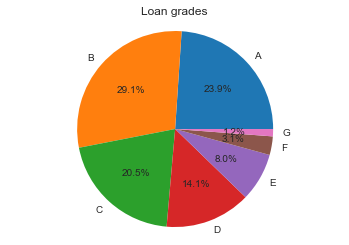

In [133]:
# plot pie chart for grade
gdata = loanData3['grade'].value_counts().sort_index()
fig = plt.figure()
plt.title('Loan grades')
sizes = gdata.values
labels = gdata.index.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=0)
plt.axis('equal')
fig.savefig('grade_pie2.png', bbox_inches='tight')
plt.show()

In [134]:
auxLoanData = loanData3[['grade','int_rate']].copy()
auxLoanData.dropna(axis=0, how='any')
auxLoanData.replace(to_replace={'grade':{'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}}, inplace=True)
auxLoanData['int_rate'] = pd.to_numeric(auxLoanData['int_rate'].str.strip('%'), errors='coerce')

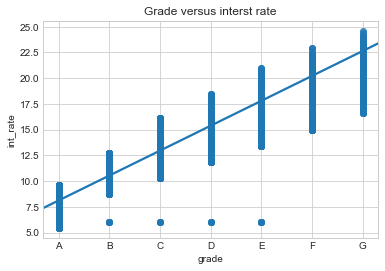

In [135]:
fig = plt.figure()
g = sns.regplot(x="grade", y="int_rate",data=auxLoanData)
plt.title('Grade versus interst rate')
plt.xticks(range(1,8),['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.show()
fig.savefig('grade_int_rate', bbox_inches='tight')

In [136]:
print(loanData3['emp_length'].unique())
print(loanData3['emp_length'].value_counts())

['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' 'n/a' nan]
10+ years    9369
< 1 year     5062
2 years      4743
3 years      4364
4 years      3649
1 year       3595
5 years      3458
6 years      2375
7 years      1875
8 years      1592
9 years      1341
n/a          1112
Name: emp_length, dtype: int64


In [137]:
print(loanData3['home_ownership'].unique()) # .describe()
print(loanData3['home_ownership'].value_counts())

['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' nan]
RENT        20181
MORTGAGE    18959
OWN          3251
OTHER         136
NONE            8
Name: home_ownership, dtype: int64


In [138]:
auxLoanData = loanData3[['grade','home_ownership']].copy()
auxLoanData.dropna(axis=0, how='any', inplace=True)
hown = auxLoanData.groupby(loanData3['home_ownership']).count()

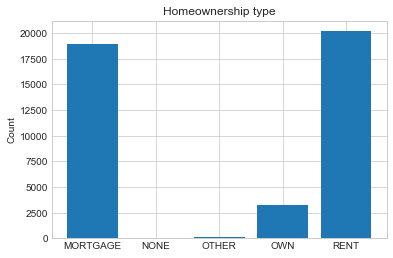

In [139]:
fig = plt.figure()

y_pos = np.arange(hown.shape[0])
auxData = hown['grade'].values
 
plt.bar(y_pos, auxData, align='center', alpha=1)
plt.xticks(y_pos, hown.index)
plt.ylabel('Count')
plt.title('Homeownership type')
fig.savefig('homeownership.png',bbox_inches='tight')
plt.show()


In [140]:
print(loanData3['verification_status'].unique())
print(loanData3['verification_status'].value_counts())

['Verified' 'Source Verified' 'Not Verified' nan]
Not Verified       18758
Verified           13471
Source Verified    10306
Name: verification_status, dtype: int64


In [141]:
print(loanData3['loan_status'].unique())
print(loanData3['loan_status'].value_counts())

['Fully Paid' 'Charged Off' nan
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']
Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64


In [142]:
auxLoanData = loanData3[['grade','loan_status']].copy()
auxLoanData.dropna(axis=0, how='any', inplace=True)

In [143]:
grades = sorted(list(set(list(auxLoanData['grade'].values))))

In [144]:
replaceDict = {'Does not meet the credit policy. Status:Fully Paid':'Fully Paid',
              'Does not meet the credit policy. Status:Charged Off':'Charged Off'}
auxLoanData.replace(to_replace={'loan_status': replaceDict}, inplace=True)

In [145]:
defaults = []
for g in grades:
    chargedOff = (auxLoanData['loan_status']=='Charged Off') & (auxLoanData['grade']==g)
    fullyPaid = (auxLoanData['loan_status']=='Fully Paid') & (auxLoanData['grade']==g)
    nChargedOff = auxLoanData[chargedOff].shape[0]
    nFullyPaid = auxLoanData[fullyPaid].shape[0]
    defaults.append(float(nChargedOff)/float(nChargedOff + nFullyPaid))

In [146]:
defData = pd.DataFrame({'grade': range(1,len(grades)+1), 'defaults':defaults})

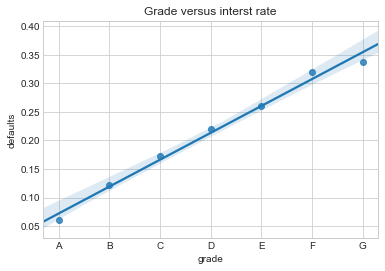

In [147]:
fig = plt.figure()
g = sns.regplot(x="grade", y="defaults",data=defData)
plt.title('Grade versus interst rate')
plt.xticks(range(1,8),grades)
plt.show()
fig.savefig('grade_defaults', bbox_inches='tight')

In [148]:
print(loanData3['purpose'].unique())
print(loanData3['purpose'].value_counts())

['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational' nan]
debt_consolidation    19776
credit_card            5477
other                  4425
home_improvement       3199
major_purchase         2311
small_business         1992
car                    1615
wedding                1004
medical                 753
moving                  629
house                   426
educational             422
vacation                400
renewable_energy        106
Name: purpose, dtype: int64


In [149]:
#'open_acc', 'pub_rec', 'total_acc'
print(loanData3['total_acc'].unique())
# print(loanData3['total_acc'].value_counts())

['9' '4' '10' '37' '38' '12' '11' '13' '3' '23' '34' '29' '28' '42' '14'
 '22' '21' '17' '7' '31' '44' '26' '16' '6' '18' '27' '24' '25' '40' '35'
 '8' '20' '15' '19' '36' '51' '32' '30' '33' '46' '5' '61' '56' '50' '41'
 '39' '79' '62' '43' '47' '53' '45' '60' '55' '52' '58' '54' '57' '49' '63'
 '48' '59' '77' '87' '75' '72' '64' '67' '78' '76' '74' '66' '81' '90' '80'
 '71' '69' '73' '70' '68' '65' '2' nan '1']


In [150]:
print(loanData3['term'].unique())

[' 36 months' ' 60 months' nan]


In [151]:
auxLoanData = loanData3[['grade','term']].copy()
auxLoanData.dropna(axis=0, how='any', inplace=True)
terms = auxLoanData.groupby(loanData3['term']).count()

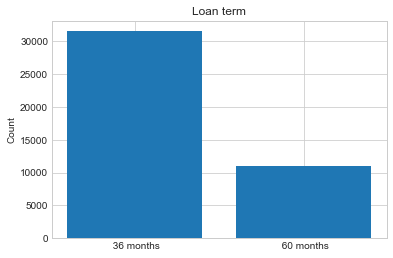

In [152]:
fig = plt.figure()

y_pos = np.arange(terms.shape[0])
auxData = terms['grade'].values
 
plt.bar(y_pos, auxData, align='center', alpha=1)
plt.xticks(y_pos, terms.index)
plt.ylabel('Count')
plt.title('Loan term')
 
plt.show()
fig.savefig('loan_term.png',bbox_inches='tight')

In [153]:
print(loanData3['addr_state'].unique())
print(loanData3['addr_state'].value_counts())

['AZ' 'GA' 'IL' 'CA' 'OR' 'NC' 'TX' 'VA' 'MO' 'CT' 'UT' 'FL' 'NY' 'PA' 'MN'
 'NJ' 'KY' 'OH' 'SC' 'RI' 'LA' 'MA' 'WA' 'WI' 'AL' 'CO' 'KS' 'NV' 'AK' 'MD'
 'WV' 'VT' 'MI' 'DC' 'SD' 'NH' 'AR' 'NM' 'MT' 'HI' 'WY' 'OK' 'DE' 'MS' 'TN'
 'IA' 'NE' 'ID' 'IN' 'ME' nan]
CA    7429
NY    4065
FL    3104
TX    2915
NJ    1988
IL    1672
PA    1651
GA    1503
VA    1487
MA    1438
OH    1329
MD    1125
AZ     933
WA     888
CO     857
NC     830
CT     816
MI     796
MO     765
MN     652
NV     527
WI     516
SC     489
AL     484
OR     468
LA     461
KY     359
OK     317
KS     298
UT     278
AR     261
DC     224
RI     208
NM     205
NH     188
WV     187
HI     181
DE     136
MT      96
WY      87
AK      86
SD      67
VT      57
TN      32
MS      26
IN      19
IA      12
NE      11
ID       9
ME       3
Name: addr_state, dtype: int64


# Clean data - Part B 

In [154]:
loanData3.replace(to_replace='n/a',value=np.nan, inplace=True)
loanData5 = loanData3.dropna(axis=0, how='any')

In [155]:
# add new feature - loan amount to annual income
loanData6 = loanData5.copy()
loanData6['amnt_pct_inc'] = loanData6['funded_amnt'].astype(float)/loanData6['annual_inc'].astype(float)

In [156]:
# We group part of the data into 2 categories of about the same size.
loanData7 = loanData6.copy()
loanData7.replace(to_replace='A',value='high', inplace=True)
loanData7.replace(to_replace=['D','E','F'],value='low', inplace=True)

In [157]:
loanData8 = loanData7[(loanData7['grade']=='high') | (loanData7['grade']=='low')]

In [158]:
dropCols3 = ['funded_amnt_inv','int_rate','installment','emp_length','issue_d','loan_status','purpose','addr_state', 'earliest_cr_line']
loanData9 = loanData8.copy()
loanData9.drop(dropCols3, axis=1,inplace=True)

In [159]:
for c in loanData9.columns:
    print(c)

funded_amnt
term
grade
home_ownership
annual_inc
verification_status
dti
open_acc
pub_rec
revol_bal
revol_util
total_acc
amnt_pct_inc


In [160]:
loanData9['revol_util'] = pd.to_numeric(loanData9['revol_util'].str.strip('%'), errors='coerce')
numericCols = ['funded_amnt','dti','open_acc', 'pub_rec','revol_bal','total_acc','amnt_pct_inc']
for c in numericCols:
    loanData9[c] = pd.to_numeric(loanData9[c], errors='coerce')

In [161]:
catFeatures = ['term', 'home_ownership','verification_status']
numFeatures = [c for c in loanData9.columns if (c not in catFeatures) & (c!='grade') ]

In [162]:
numFeatures

['funded_amnt',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'amnt_pct_inc']

# Clean Data - Part 3 - Structure data

We need to preprocess continuous data because the data doesn't have the same scale (and so Logistic Regression or SVM doesn't make sense). 

There are a few possibilities:
1. preprocessing.scale (this removes the mean and divides by standard deviation)
2. preprocessing.QuantileTransformer (this transforms the data into quantiles)

Note: 

Both of these transformations work full sample and thus there will be an implicit "look-ahead" bias in any fit that does not apply the preprocessing to the train and test sets separately. We will ignore this bias for two reasons:
a. simplicy and 
b. because given the data set (the large size) it is reasonable that the ranges would not be different for the in-sample and out-of sample (unless the ordering of the data leads to some bias).

In practice, Lending Club has a range/quantile approach to how they look at the data, but it is probably defined by LC and not necessarily by the data (as in our case)

Possible solution: randomize the order of the data prior to the fit. 

In [ ]:
# version A: preprocessing.scale
# loanDataNum = pd.DataFrame(preprocessing.scale(loanData9[numFeatures]), index=loanData9.index, columns=numFeatures)

In [163]:
# version B: preprocessing.QUantileTransformer
qt = preprocessing.QuantileTransformer(n_quantiles=10,random_state=0)
loanDataNum = pd.DataFrame()
for ii in range(0, len(numFeatures)):
    qt.fit_transform(loanData9[numFeatures[ii]].values.reshape(-1, 1))
    loanDataNum = loanDataNum.join(
        pd.DataFrame(qt.transform(loanData9[numFeatures[ii]].values.reshape(-1, 1)), index=loanData9.index, columns=[numFeatures[ii]]),how='right')

VERSION 1 - for Logistic Regression and SVM we turn categorical variables into dummy variables

In [164]:
loanDataCat = pd.get_dummies(loanData9[catFeatures])

In [165]:
Y = loanData9['grade'].to_frame()
Y.replace(to_replace='high', value='1', inplace=True)
Y.replace(to_replace='low', value='0', inplace=True)
Y = pd.to_numeric(Y.iloc[:,0], errors='coerce')
Y = Y.to_frame()
X = loanDataNum.join(loanDataCat, how='left')

# used for full sample fit and cross-validation-score for Logistic Regression
XX = X.values
YY = Y.values.reshape(-1,)

In [166]:
np.random.seed(0)
perm = np.random.permutation(range(0, YY.shape[0]))

In [167]:
trainIdx = perm[:int(np.floor(0.75*XX.shape[0]))]
testIdx = perm[int(np.floor(0.75*XX.shape[0])):]

In [168]:
# use to test only one fit (e.g. random forest)
XX_train = XX[trainIdx,:]
XX_test = XX[testIdx,:]

YY_train = YY[trainIdx]
YY_test = YY[testIdx]

VERSION 2 - for Decision Tree and Random Forest classifiers we turn categorical variables into labels

In [169]:
le = preprocessing.LabelEncoder()
loanDataCat2 = pd.DataFrame()
for ii in range(0, len(catFeatures)):
    le.fit(loanData9[catFeatures[ii]])
    loanDataCat2 = loanDataCat2.join(
        pd.DataFrame(le.transform(loanData9[catFeatures[ii]]), index=loanData9.index, columns=[catFeatures[ii]]),how='right')

X2 = loanDataNum.join(loanDataCat2, how='left')
Y2 = Y.copy()

# used for full sample fit and cross-validation-score for Decision Tree, SVM and Random Forest
XX2 = X2.values
YY2 = Y2.values.reshape(-1,)

# use to test only one fit (e.g. random forest)
XX2_train = XX2[trainIdx,:]
XX2_test = XX2[testIdx,:]

YY2_train = YY2[trainIdx]
YY2_test = YY2[testIdx]

In [170]:
# the data set is balanced (roughly equal number of the two states)
print('Number of \"high quality\" loans (i.e. Y=1) is {:.2f}%'.format(100*float(Y.sum()/Y.shape[0])))

Number of "high quality" loans (i.e. Y=1) is 48.27%


General parameters:
1. number of features
2. number of quantiles
3. number of folds in cross validation

# Fit models

Objectives (absolute and relative):
1. good cross validation score
2. the simpler the better
3. the more interpretable the better

We will try: logistic regression, decision tree, SVM, random forests.

We will also take a look at the feature importances and their ranking so as to both get understanding and do a sanity check on whether the results make sense. 

In [171]:
def runFit(clfStr, XX, YY, XX_train, YY_train, XX_test, YY_test):
    if (clfStr=='lr'):
        clf1 = LogisticRegression(penalty='l2', C=1e9)
        clf2 = LogisticRegression(penalty='l2', C=1e9)
        clf3 = LogisticRegression(penalty='l2', C=1e9)
        
    if (clfStr=='svm'):
        clf1 = SVC()
        clf2 = SVC()
        clf3 = SVC()

    if (clfStr=='dtc'):
        clf1 = DecisionTreeClassifier(criterion='gini')
        clf2 = DecisionTreeClassifier(criterion='gini')
        clf3 = DecisionTreeClassifier(criterion='gini')
        
    if (clfStr=='rfc'):
        clf1 = RandomForestClassifier(n_estimators=10)
        clf2 = RandomForestClassifier(n_estimators=10)
        clf3 = RandomForestClassifier(n_estimators=10)

    # full sample
    clf1.fit(XX,YY)
    fss = clf1.score(XX,YY)        
    
    if clfStr == 'lr':
        fi = clf1.coef_
    elif clfStr == 'dtc' :
        fi = clf1.feature_importances_
    elif clfStr == 'rfc' :
        fi = clf1.feature_importances_
    else :
        fi = np.nan
        
    # trainTest        
    clf2.fit(XX_train, YY_train)
    tts = clf2.score(XX_test, YY_test)
        
    # cross validation score
    cvs = cross_val_score(clf3, XX, YY, cv=10)
        
    return fss, tts, cvs, fi 

In [172]:
classifiers =['lr','dtc','svm','rfc'] 
fullSampleScores = []
trainTestScores = []
cvScores = []
featureImportances = []

for clfStr in classifiers:
    if ((clfStr =='lr') | (clfStr == 'svm')):
        fss, tts, cvs, fi = runFit(clfStr, XX, YY, XX_train, YY_train, XX_test, YY_test)
    else:
        fss, tts, cvs, fi = runFit(clfStr, XX2, YY2, XX2_train, YY2_train, XX2_test, YY2_test)
    
    fullSampleScores.append(fss)
    trainTestScores.append(tts)
    cvScores.append(cvs)
    featureImportances.append(fi)

Model parameters:

A. LR:
    1. type of optimization (l2, Ridge, Lasso)
    2. optimization C
B. DTC:
    1. criterion (gini or entropy)
    2. size of tree
C. SVC:
    1. kernel (linear, rbf)
    2. gamma
    3. optimization C
D. RFC:
    1. number of trees in forest
    2. size of tree/forest


# Model fit comparison

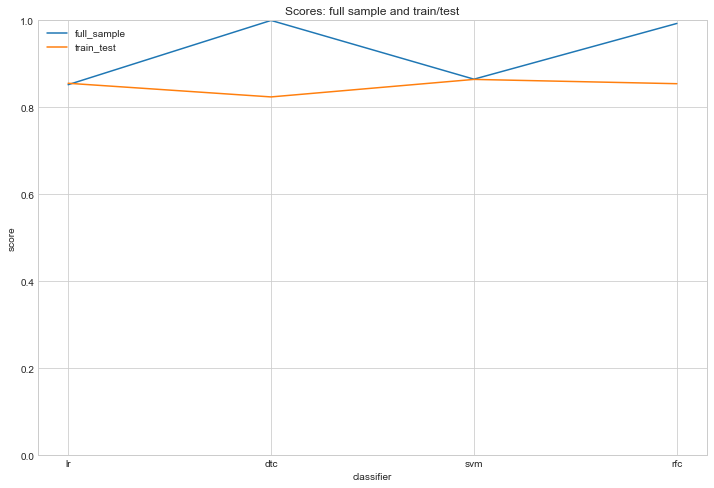

In [173]:
# full sample scores
fssVec = np.array(fullSampleScores)
ttsVec = np.array(trainTestScores)

fig = plt.figure(figsize=(12,8))
plt.plot(range(0,len(fssVec)), fssVec, label='full_sample')
plt.plot(range(0,len(ttsVec)), ttsVec, label='train_test')
plt.title('Scores: full sample and train/test')
plt.xticks(range(len(classifiers)), classifiers, rotation=0)
plt.legend(loc='best')
plt.xlabel('classifier')
plt.ylabel('score')
plt.grid(b='on')
plt.ylim([0.0,1.0])
plt.show()
fig.savefig('fullSampleTrainTest.png', bbox_inches='tight')

In [174]:
cvsDf = pd.DataFrame(columns=['score','classifier'])
for c,ii in zip(classifiers, range(0,len(classifiers))):
    auxDf = pd.DataFrame(data=cvScores[ii], index=range(len(cvScores[ii])),columns=['score'])
    auxDf['classifier']= c  
    cvsDf = cvsDf.append(auxDf, ignore_index=True)

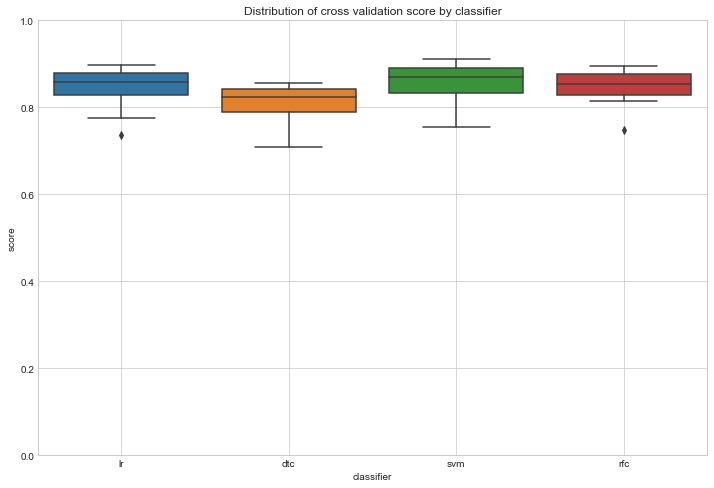

In [175]:
fig = plt.figure(figsize=(12,8))
sns.boxplot(x='classifier', y='score', data=cvsDf)
plt.title('Distribution of cross validation score by classifier')
plt.grid(b='on')
plt.ylim([0,1])
plt.show()
fig.savefig('cross_val_score.png', bbox_inches='tight')

In [176]:
# feature importances (ranking)
fiDf = pd.DataFrame()
for c,ii in zip(classifiers, range(0,len(classifiers))):
    fi = featureImportances[ii]
    
    if ((c =='lr') | (c == 'svm')):
        auxFeat = X.columns
    else:
        auxFeat = X2.columns
    if np.size(fi)==1:
        fi = np.nan*np.zeros(shape=[len(auxFeat),1])
    auxDf = pd.DataFrame(data=fi.reshape(len(auxFeat),1), index=auxFeat, columns=[c])
    fiDf = fiDf.join(auxDf, how='outer')

In [177]:
fiDf2 = pd.DataFrame()
for c,ii in zip(classifiers, range(0,len(classifiers))):
    fi = featureImportances[ii]
    
    if ((c =='lr') | (c == 'svm')):
        auxFeat = X.columns
    else:
        auxFeat = X2.columns
    if np.size(fi)==1:
        fi = np.nan*np.zeros(shape=[len(auxFeat),1])
    auxData = np.concatenate((auxFeat.values.reshape(len(auxFeat),1),fi.reshape(len(auxFeat),1)),axis=1)
    auxDf = pd.DataFrame(data=auxData, columns=[c+'_feature',c+'_rank'])
    fiDf2 = fiDf2.join(auxDf,how='outer')

In [ ]:
fiDf2

In [178]:
fiDf3 = pd.DataFrame()
for c,ii in zip(classifiers, range(0,len(classifiers))):
    fi = featureImportances[ii]
    
    if ((c =='lr') | (c == 'svm')):
        auxFeat = X.columns
    else:
        auxFeat = X2.columns
    if np.size(fi)==1:
        fi = np.nan*np.zeros(shape=[len(auxFeat),1])
        
    auxDf = pd.DataFrame(data=fi.reshape(len(auxFeat),1), index=auxFeat, columns=[c+'_imp'])
    if c=='lr':
        auxDf = auxDf.applymap(lambda x: np.abs(x))
        
    auxDf[c+'_rank'] = auxDf.rank(axis=0, ascending=True)
    maxVal = auxDf[c+'_rank'].max()
    auxDf[c+'_rank'] = 100/maxVal*auxDf[c+'_rank']
    
    fiDf3 = fiDf3.join(auxDf,how='outer')

In [179]:
fiDf3.drop([c+'_imp' for c in classifiers], axis=1, inplace=True)

In [180]:
fiDf3.drop(['svm_rank'], axis=1, inplace=True)

In [181]:
fiDf3 = fiDf3.applymap(lambda x: np.floor(x))

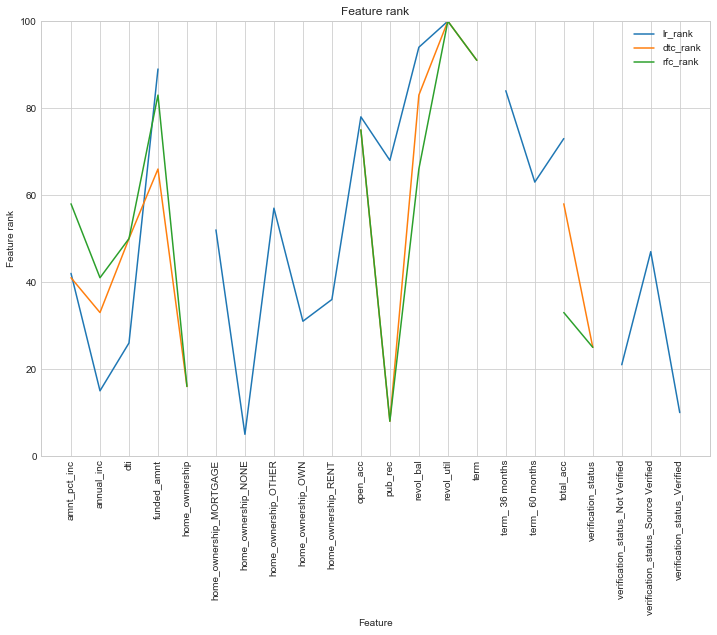

In [182]:
fig = plt.figure(figsize=(12,8))
for c in fiDf3.columns:
    plt.plot(range(0,fiDf3.shape[0]), fiDf3[c], label=c)

plt.title('Feature rank')
plt.xticks(range(0,fiDf3.shape[0]), fiDf3.index, rotation=90)
plt.ylim([0,100])
plt.grid(b='on')
plt.legend(loc='best')
plt.xlabel('Feature')
plt.ylabel('Feature rank')
plt.show()
fig.savefig('feature_rank.png', bbox_inches='tight')

In [187]:
lrCoeff = pd.DataFrame(featureImportances[0].reshape(-1,1), index=X.columns, columns=['Coefficient'])

In [192]:
lrCoeff.sort_values(by=['Coefficient'],ascending=False, inplace=True)

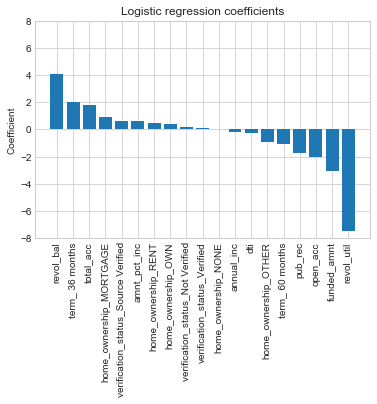

In [195]:
fig = plt.figure()

y_pos = np.arange(lrCoeff.shape[0])
auxData = lrCoeff['Coefficient'].values
 
plt.bar(y_pos, auxData, align='center', alpha=1)
plt.xticks(y_pos, lrCoeff.index, rotation=90)
plt.ylabel('Coefficient')
plt.ylim([-8,8])
plt.title('Logistic regression coefficients')
 
plt.show()
fig.savefig('lr_coefficients.png',bbox_inches='tight')